In [1]:
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import pandas as pd
from PIL import Image, ImageOps

In [2]:
!pip install nlpaug
import nlpaug.augmenter.word as naw

In [3]:
!pip install sentencepiece
!pip install transformers
from transformers import XLNetTokenizer, TFXLNetModel

In [4]:
!pip install --upgrade scikit-learn

In [5]:
!pip install efficientnet
from efficientnet.tfkeras import EfficientNetB3

In [6]:
# Load XLNet model and tokenizer
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetMo

Load EfficientNet model

In [7]:
efficientnet_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/MultiOFF_Dataset.zip", "/content/Datasets/")

In [10]:
dataset_path = '/content/Datasets/MultiOFF_Dataset/Split Dataset'

train_df = pd.read_csv(os.path.join(dataset_path, 'Training_meme_dataset.csv'))
test_df = pd.read_csv(os.path.join(dataset_path, 'Testing_meme_dataset.csv'))
val_df = pd.read_csv(os.path.join(dataset_path, 'Validation_meme_dataset.csv'))

In [11]:
image_folder = '/content/Datasets/MultiOFF_Dataset/Labelled Images'
train_df['image_name'] = train_df['image_name'].apply(lambda x: os.path.join(image_folder, x))
test_df['image_name'] = test_df['image_name'].apply(lambda x: os.path.join(image_folder, x))
val_df['image_name'] = val_df['image_name'].apply(lambda x: os.path.join(image_folder, x))

In [12]:
train_df.head()

,image_name,sentence,label
0,/content/Datasets/MultiOFF_Dataset/Labelled Im...,OFFICIAL BERNIE SANDERS DRINKING GAME ! Every ...,Non-offensiv
1,/content/Datasets/MultiOFF_Dataset/Labelled Im...,2:28 PM THIS IS A WALL INSIDE A NAZI GAS CHAMB...,offensive
2,/content/Datasets/MultiOFF_Dataset/Labelled Im...,o shit waddup ! BERNIE SANDERS COM,offensive
3,/content/Datasets/MultiOFF_Dataset/Labelled Im...,`` MITT ROMNEY IS THE WORST REPUBLICAN IN THE ...,Non-offensiv
4,/content/Datasets/MultiOFF_Dataset/Labelled Im...,Anonymous ( ID : duqdA1io a 08/05/16 ( Fri ) 1...,Non-offensiv


In [13]:
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2

def preprocess_image(image):
    target_size = (224, 224)

    # Resize the image
    if isinstance(target_size, tuple) and len(target_size) == 2 and target_size[0] > 0 and target_size[1] > 0:
        if image.shape[:2] != target_size:
            image_resized = cv2.resize(image, target_size)
        else:
            image_resized = image

    # Ensure the image has 3 channels
    if len(image_resized.shape) == 2:
        image_resized = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    elif image_resized.shape[2] == 4:
        image_resized = image_resized[:, :, :3]  # Keep only the first 3 channels

    # Apply preprocessing specific to EfficientNet
    preprocessed_image = preprocess_input(image_resized)

    return preprocessed_image


In [14]:
def load_images_from_df(df):
    image_samples = []

    for image_name in df['image_name']:
        image = Image.open(image_name)
        image_array = np.array(image)  # Convert Image to numpy array
        preprocessed_image = preprocess_image(image_array)
        image_samples.append(preprocessed_image)

    return image_samples

In [15]:
image_train = load_images_from_df(train_df)
image_test = load_images_from_df(test_df)
image_val = load_images_from_df(val_df)

In [16]:
text_train = train_df['sentence'].tolist()
text_test = test_df['sentence'].tolist()
text_val = val_df['sentence'].tolist()
len(text_train)

445

In [17]:
labels_train = train_df['label'].values
labels_test = test_df['label'].values
labels_val = val_df['label'].values

In [18]:
label_mapping = {'Non-offensiv': 0, 'offensive': 1}
labels_train = np.array([label_mapping[label] for label in labels_train])
labels_test = np.array([label_mapping[label] for label in labels_test])
labels_val = np.array([label_mapping[label] for label in labels_val])

In [19]:
# Import the necessary library
import nlpaug.augmenter.word as naw
# Define a function for text data augmentation
def augment_text_data(text_data):
    # Initialize the augmentation object
    aug = naw.SynonymAug(aug_src='wordnet')
    return aug.augment(text_data)


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
image_data_generator = ImageDataGenerator(
    rotation_range=8,      # Random rotation (degrees)
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Fill mode for filling in newly created pixels
)

In [22]:
import spacy

# Load the spaCy English model (you may need to download it first)
nlp = spacy.load("en_core_web_sm")

# Function to extract meaningful text from a sentence
def extract_meaningful_text(sentence):
    doc = nlp(sentence)
    meaningful_words = []
    for token in doc:
        # Filter out stopwords and punctuation
        if not token.is_stop and not token.is_punct:
            meaningful_words.append(token.text)
    return meaningful_words

In [23]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random

# Load a TrueType font (.ttf) file
font_path = '/content/drive/MyDrive/arial.ttf'

# Function to overlay text on an image
def overlay_text(image, text):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Set a range for font size
    min_font_size = 10
    max_font_size = 36
    font_size = random.randint(min_font_size, max_font_size)  # Random font size

    font = ImageFont.truetype(font_path, font_size)

    # Join the list elements into a single string
    text = ' '.join(text)


    # Split the text into individual words
    # words = text.split()
    words = extract_meaningful_text(text)

    for word in words:
        text_width, text_height = draw.textsize(word, font=font)
        x = random.randint(0, width - text_width)
        y = random.randint(0, height - text_height)
        draw.text((x, y), word, fill="white", font=font)

    return np.array(image)


augmented_text = []  # A list to store augmented text data
augmented_images = []  # A list to store augmented images

for i in range(len(text_train)):
    # Randomly select an image index for augmentation
    if len(text_train) > 0:
      swapped_idx = random.randint(0, len(text_train) - 1)
      # Apply image augmentation
      image_data = image_data_generator.random_transform(image_train[swapped_idx])
      # Overlay text on the augmented image
      image_with_text = overlay_text(image_data, text_train[i])

      # Apply text augmentation
      text_train[i] = augment_text_data(text_train[i])

      # Tokenize and limit sequence length for text data
      tokens = xlnet_tokenizer(text_train[i], truncation=True, padding='max_length', max_length=128)
      # Append the augmented text and image data
      augmented_text.append(' '.join(tokens))

      # Preprocess the image
      preprocessed_image = preprocess_image(image_with_text)

      augmented_images.append(preprocessed_image)


Streaming output truncated to the last 5000 lines.
<ipython-input-23-7c7f401daf39>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-7c7f401daf39>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-7c7f401daf39>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-7c7f401daf39>:30: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(word, font=font)
<ipython-input-23-7c7f401daf39>:30: DeprecationWarning: textsize 

In [24]:
# Tokenize and encode the augmented text data using the XLNet tokenizer
text_encodings = xlnet_tokenizer(augmented_text, padding=True, truncation=True, return_tensors='tf')

# Get the input IDs for the text data
input_ids = text_encodings['input_ids']
attention_mask = text_encodings['attention_mask']

# Generate embeddings for text data
text_embeddings = xlnet_model(input_ids, attention_mask=attention_mask)["last_hidden_state"]


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [25]:
batch_size = 80  # Adjust this for RAM usage
num_samples = len(augmented_text)
num_batches = (num_samples + batch_size - 1) // batch_size

In [26]:
# Convert image data to TensorFlow tensor
# Ensure all images have the same dimensions
# augmented_image = [img for img in augmented_image if img.shape == (224, 224, 3)]

# Convert the list of images to a 4D NumPy array
image_data = np.stack(augmented_images)

# Convert the NumPy array to a TensorFlow tensor
image_data = tf.convert_to_tensor(image_data, dtype=tf.float32)
# image_data = tf.convert_to_tensor(image_data, dtype=tf.float32)

In [27]:
image_data.shape

TensorShape([445, 224, 224, 3])

In [28]:
# Process image data through EfficientNet
image_embeddings = efficientnet_model.predict(image_data)

14/14 [==============================] - 6s 153ms/step


In [29]:
from tensorflow.keras.layers import Dense

# Add a Dense layer to reduce the dimensionality of text embeddings
text_embeddings = Dense(62720, activation='relu')(text_embeddings)


In [30]:
# ... (previous parts of your code)

# Flatten the image embeddings
flattened_image_embeddings = tf.keras.layers.Flatten()(image_embeddings)
# Flatten the text embeddings
flattened_text_embeddings = tf.keras.layers.Flatten()(text_embeddings)

# Concatenate the flattened text embeddings with the flattened image embeddings
combined_embeddings = tf.concat([flattened_text_embeddings, flattened_image_embeddings], axis=1)

In [31]:
image_embeddings.shape

(445, 7, 7, 1536)

In [32]:
text_embeddings.shape

TensorShape([445, 14, 62720])

In [33]:
combined_embeddings.shape

TensorShape([445, 953344])

In [34]:
from tensorflow.keras.callbacks import LearningRateScheduler

# # Define a learning rate schedule function
# def step_decay(epoch):
#     initial_lr = 0.001  # Initial learning rate
#     drop = 0.01         # Factor by which the learning rate will be reduced
#     epochs_drop = 5   # Number of epochs after which learning rate will drop
#     lr = initial_lr * (drop ** (epoch // epochs_drop))
#     return lr

# # Create an instance of LearningRateScheduler
# lr_scheduler = LearningRateScheduler(step_decay)

def exponential_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    decay_rate = 0.98  # Decay rate
    lr = initial_lr * decay_rate ** epoch
    return lr

# Create an instance of LearningRateScheduler
lr_scheduler = LearningRateScheduler(exponential_decay)


In [35]:
# import tensorflow.keras.losses.losses_utils as losses_utils

class WeightedLoss(tf.keras.losses.Loss):
  def __init__(self, weights, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE):
    self.weights = weights
    self._name_scope = 'weighted_loss'
    self.reduction = reduction

  def call(self, y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    loss = tf.reduce_mean(loss * self.weights)
    return loss

In [36]:

from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input

# Create a Keras model for the image branch
image_input = Input(shape=(7, 7, 1536), name='image_input')
image_flattened = Flatten()(image_input)
image_dense = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.003))(image_flattened)
image_dropout = Dropout(0.5)(image_dense)

# Create a Keras model for the text branch
main_input = Input(shape=(10, 62720), dtype='float32', name='main_input') # Adjust input shape
text_flattened = Flatten()(main_input)
text_dense = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.003))(text_flattened)
text_dropout = Dropout(0.5)(text_dense)

# Combine the text and image models
combined_features = Concatenate()([text_dropout, image_dropout])
combined_dense = Dense(256, activation='relu')(combined_features)
combined_final_output = Dense(1, activation='sigmoid')(combined_dense)

# Create the final model
combined_model = Model(inputs=[main_input, image_input], outputs=combined_final_output)

# Compile the model
focal_loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2, alpha=0.8)
# combined_model.compile(optimizer='adam', loss=WeightedLoss(weights=[1, 10]), metrics=['accuracy'])
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 10, 62720)]          0         []                            
                                                                                                  
 image_input (InputLayer)    [(None, 7, 7, 1536)]         0         []                            
                                                                                                  
 flatten_3 (Flatten)         (None, 627200)               0         ['main_input[0][0]']          
                                                                                                  
 flatten_2 (Flatten)         (None, 75264)                0         ['image_input[0][0]']         
                                                                                              

In [37]:
import tensorflow as tf
# Splitting the data using indices
indices = np.arange(len(text_embeddings))
indices_train, indices_val, _, _ = train_test_split(
    indices, labels_train, test_size=0.2, random_state=42
)
# Convert NumPy arrays to TensorFlow tensors
indices_train_tf = tf.convert_to_tensor(indices_train)
indices_val_tf = tf.convert_to_tensor(indices_val)

X_train_text = tf.gather(text_embeddings, indices_train_tf)
X_val_text = tf.gather(text_embeddings, indices_val_tf)
X_train_img = tf.gather(image_embeddings, indices_train_tf)
X_val_img = tf.gather(image_embeddings, indices_val_tf)
y_train = tf.gather(labels_train, indices_train_tf)
y_val = tf.gather(labels_train, indices_val_tf)

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the text data to have a sequence length of 10
X_train_text_padded = pad_sequences(X_train_text, maxlen=10, padding='post', truncating='post', dtype='float32')
X_val_text_padded = pad_sequences(X_val_text, maxlen=10, padding='post', truncating='post', dtype='float32')

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Define a model checkpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.h5',        # Filepath to save the best model
    monitor='val_accuracy',     # Monitor validation loss
    save_best_only=True,    # Save only the best model
    verbose=1                # Verbosity mode, 1 for progress bar
)

In [40]:
np.unique(labels_train)

array([0, 1])

In [41]:
import numpy as np

# Assuming labels_train contains your training labels
unique_classes, class_counts = np.unique(labels_train, return_counts=True)
total_samples = len(labels_train)

# Calculate class weights as inversely proportional to class frequencies
class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}

In [42]:
history = combined_model.fit(
        [X_train_text_padded, X_train_img],
        y_train,
        batch_size=batch_size,
        epochs=10,  # Only one epoch per iteration
        validation_data=([X_val_text_padded, X_val_img], y_val),
        class_weight=class_weights,
        callbacks=[lr_scheduler, early_stopping, model_checkpoint]
    )


Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 23918.5332 - accuracy: 0.4747
Epoch 1: val_accuracy improved from -inf to 0.52809, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 10s 2s/step - loss: 23918.5332 - accuracy: 0.4747 - val_loss: 9922.5059 - val_accuracy: 0.5281 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 14174.3789 - accuracy: 0.5197
Epoch 2: val_accuracy did not improve from 0.52809
5/5 [==============================] - 1s 158ms/step - loss: 14174.3789 - accuracy: 0.5197 - val_loss: 8684.4385 - val_accuracy: 0.5281 - lr: 9.8000e-04
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 7645.1294 - accuracy: 0.5534
Epoch 3: val_accuracy did not improve from 0.52809
5/5 [==============================] - 1s 152ms/step - loss: 7645.1294 - accuracy: 0.5534 - val_loss: 9648.1396 - val_accuracy: 0.4607 - lr: 9.6040e-04
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 9018.4551 - accuracy: 0.5449
Epoch 4: val_accuracy did not improve from 0.52809
5/5 [==============================] - 1s 152ms/step - loss: 9018.4551 - accuracy: 0.5449 - val_loss: 8834.02

In [43]:
history.history

{'loss': [23918.533203125,
  14174.37890625,
  7645.12939453125,
  9018.455078125,
  8590.958984375,
  7131.96435546875,
  6173.669921875,
  3326.242919921875,
  3255.1689453125,
  2447.294677734375],
 'accuracy': [0.4747191071510315,
  0.5196629166603088,
  0.5533707737922668,
  0.5449438095092773,
  0.584269642829895,
  0.5786516666412354,
  0.6039325594902039,
  0.617977499961853,
  0.6348314881324768,
  0.6938202381134033],
 'val_loss': [9922.505859375,
  8684.4384765625,
  9648.1396484375,
  8834.025390625,
  9393.4677734375,
  9930.5166015625,
  7981.4423828125,
  6788.7392578125,
  5866.884765625,
  5716.07568359375],
 'val_accuracy': [0.5280898809432983,
  0.5280898809432983,
  0.4606741666793823,
  0.516853928565979,
  0.5617977380752563,
  0.5280898809432983,
  0.49438202381134033,
  0.5056179761886597,
  0.483146071434021,
  0.483146071434021],
 'lr': [0.001,
  0.00098,
  0.0009604,
  0.000941192,
  0.00092236814,
  0.0009039208,
  0.00088584237,
  0.0008681255,
  0.00085076

In [44]:
# Tokenize and encode the test texts
test_encodings = xlnet_tokenizer(text_test, truncation=True, padding=True, return_tensors='tf')

# Get the input IDs for the test data
input_ids_test = test_encodings['input_ids']
image_test = np.array(image_test)
print("Image type:", type(image_test))
print("Image shape:", image_test.shape)
preprocessed_images = []

for image_data in image_test:
    preprocessed_image = preprocess_image(image_data)
    preprocessed_images.append(preprocessed_image)

# Convert the list of preprocessed images to a NumPy array
preprocessed_images = np.array(preprocessed_images)
# Ensure that X_test_text has the same shape as expected by the model (sequence length of 10 and embedding size of 62720)
# You can pad or truncate as needed
if input_ids_test.shape[1] < 10:
    padding_size = 10 - input_ids_test.shape[1]
    input_ids_test = np.pad(input_ids_test, ((0, 0), (0, padding_size)), mode='constant')
elif input_ids_test.shape[1] > 10:
    input_ids_test = input_ids_test[:, :10]
# Now, you can use preprocessed_images for prediction with your EfficientNet model
X_test_img = efficientnet_model.predict(preprocessed_images)
X_test_text = xlnet_model.predict(input_ids_test)[0]  # Assuming the model returns a tuple and we want the first element
print("X_test_text shape:", X_test_text.shape)
print("X_test_img shape:", X_test_img.shape)

Image type: <class 'numpy.ndarray'>
Image shape: (149, 224, 224, 3)
5/5 [==============================] - 6s 47ms/step
X_test_text shape: (149, 10, 768)
X_test_img shape: (149, 7, 7, 1536)


In [45]:
import numpy as np

# Assuming X_test_text has shape (None, 10, 768)
desired_shape = (X_test_text.shape[0], 10, 62720)

# Pad with zeros if the shape is smaller, or truncate if larger
if X_test_text.shape[2] < desired_shape[2]:
    padding = np.zeros((desired_shape[0], 10, desired_shape[2] - X_test_text.shape[2]))
    X_test_text_padded = np.concatenate((X_test_text, padding), axis=2)
elif X_test_text.shape[2] > desired_shape[2]:
    X_test_text_padded = X_test_text[:, :, :desired_shape[2]]
else:
    X_test_text_padded = X_test_text  # No need to pad or truncate

X_test_text_padded.shape

(149, 10, 62720)

In [46]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model.h5')

In [47]:
test_predictions = best_model.predict([X_test_text_padded, X_test_img])

5/5 [==============================] - 0s 25ms/step


In [48]:
threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)

In [54]:
from sklearn.metrics import accuracy_score

# Assuming labels_test contains the true labels for your test data
accuracy = accuracy_score(labels_test, binary_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6836241610738255


In [55]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(labels_test, binary_predictions)
recall = recall_score(labels_test, binary_predictions)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.49756382235574
Recall: 0.60122038484857


In [56]:
from sklearn.metrics import f1_score

f1 = f1_score(labels_test, binary_predictions)
print("F1-Score:", f1)

F1-Score: 0.5073170731707318


In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_test, binary_predictions)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[74 17]
 [51  7]]


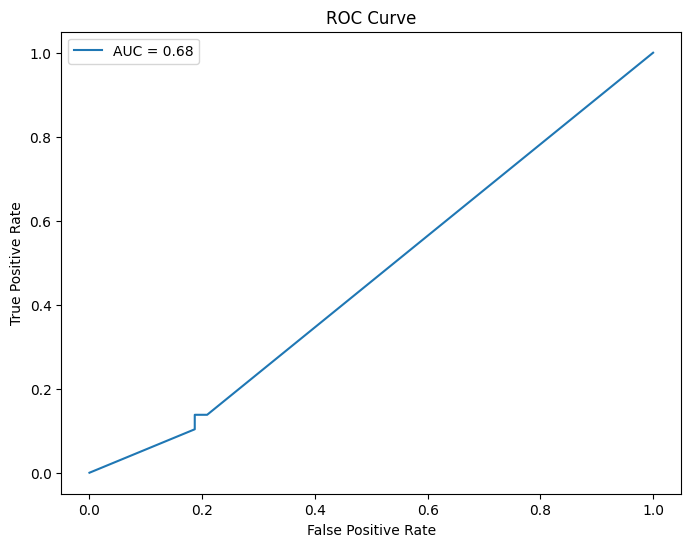

AUC: 0.6828647214854111


In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels_test, test_predictions)
auc = roc_auc_score(labels_test, test_predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("AUC:", auc)
